In [1]:
from pymmcore_slm_sim import SimSLMDevice
from pymmcore_camera_sim import SimCameraDevice
from pymmcore_plus.experimental.unicore import UniMMCore

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from skimage.io import imsave
import os

pygame 2.6.1 (SDL 2.28.4, Python 3.13.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Simulating optogenetic control of cell migration with virtual Camera/SLM devices
Using pymmcore-plus [`unicore`](https://github.com/pymmcore-plus/pymmcore-plus/blob/main/examples/unicore.py) framework

In [2]:
core = UniMMCore()

# Load the simulation devices
core.loadPyDevice("Camera", SimCameraDevice(core))
core.initializeDevice("Camera")
core.setCameraDevice("Camera")
core.loadPyDevice("SLM", SimSLMDevice())
core.initializeDevice("SLM")
core.setSLMDevice("SLM")

# make a mask with the letter 'A'
# Use the camera's shape for mask size
def get_camera_shape():
    core.snapImage()
    return core.getImage().shape

mask_shape = get_camera_shape()
mask = np.zeros(mask_shape, dtype='uint8')
pil_img = Image.fromarray(mask)
draw = ImageDraw.Draw(pil_img)
font = ImageFont.truetype("./static/Roboto-Bold.ttf", 700)
draw.text((50, -135), "D", font=font, fill=255)
mask[:, :] = np.array(pil_img)
core.setSLMImage("SLM", mask)


Error getting SLM image: No image loaded


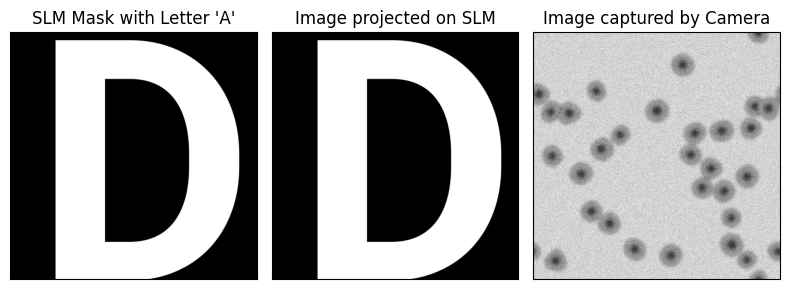

In [3]:
slm_img = core.getSLMImage("SLM")
core.snapImage()
camera_img = core.getImage()

fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title("SLM Mask with Letter 'A'")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(slm_img, cmap='gray')
axes[1].set_title("Image projected on SLM")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(camera_img, cmap='gray')
axes[2].set_title("Image captured by Camera")
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()

# Simple function to segment the simulated cells

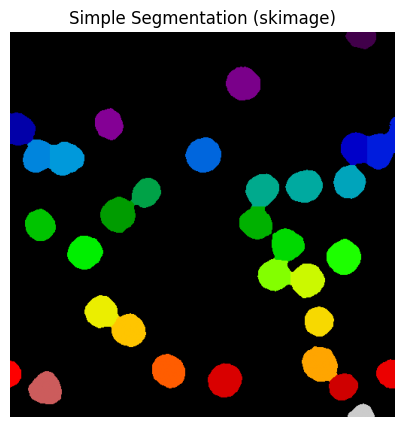

In [4]:
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects

def segment_cells(image, sigma=2, min_distance=5, min_size=100):
    blurred = gaussian(image, sigma=sigma)
    thresh = threshold_otsu(blurred)
    binary = blurred < thresh
    distance = ndi.distance_transform_edt(binary)
    local_maxi = peak_local_max(distance, labels=binary, min_distance=min_distance)
    seeds = np.zeros_like(binary, dtype=np.uint8)
    for x, y in local_maxi:
        seeds[x, y] = 1
    markers = ndi.label(seeds)[0]
    labels_ws = watershed(-distance, markers, mask=binary)
    labels_ws = remove_small_objects(labels_ws, min_size=min_size)
    return labels_ws

labels_ws = segment_cells(camera_img)
plt.figure(figsize=(5, 5))
plt.imshow(labels_ws, cmap='nipy_spectral')
plt.title("Simple Segmentation (skimage)")
plt.axis('off')
plt.show()

# Open `napari-micromanager` plugin

In [5]:
import napari
viewer = napari.Viewer()
viewer.window.add_plugin_dock_widget(
    plugin_name='napari-micromanager',
)

C:\Users\dario\anaconda3\envs\opto-loop\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\dario\anaconda3\envs\opto-loop\Lib\site-packages\napari_micromanager\main_window.py:51: FutureWarning: The `_dock_widgets` property is private and should not be used in any plugin code. Please use the `dock_widgets` property instead.
  if "MinMax" not in getattr(self.viewer.window, "_dock_widgets", []):


(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget at 0x275e2548f50>,
 <napari_micromanager.main_window.MainWindow at 0x275e03d74d0>)

# Test feedback-control loop
### Helper function to write letters as image

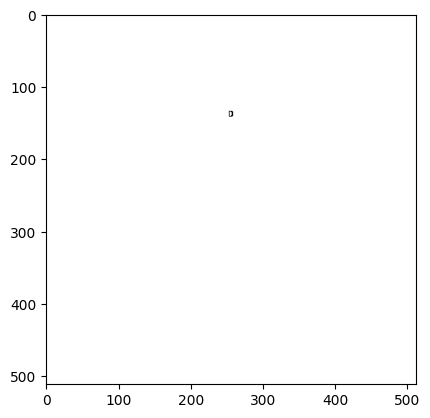

In [6]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
def mask_from_letter(letter, size=512, font_size=650, font_path="Arial.ttf"):
    """Create a binary mask from a letter, centered in the image."""
    mask = np.zeros((size, size), dtype='uint8')
    pil_img = Image.fromarray(mask)
    draw = ImageDraw.Draw(pil_img)
    # Try to load the font, fallback to default if not found
    try:
        font = ImageFont.truetype(font_path, font_size)
    except OSError:
        font = ImageFont.load_default()
    text = letter

    # Alternative: use getmask to get the actual rendered size
    mask_img = font.getmask(text)
    text_width, text_height = mask_img.size

    x = (mask.shape[1] - text_width) // 2
    y = (mask.shape[0] - text_height) // 2 -120

    draw.text((x, y), text, font=font, fill=255)
    return np.array(pil_img) > 0

plt.imshow(mask_from_letter("D"), cmap='gray_r')

### Different stimulation logic examples

In [24]:
### Different stimulation logics

#### **Move up**

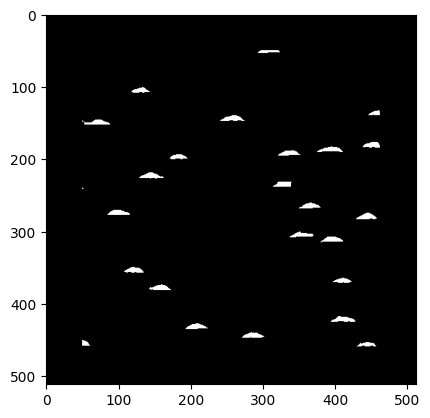

In [7]:
def labels_to_stim_mask(mask):
    """Take in a label image and return a mask for stimulation.
    For each label, we create a binary mask where the label is present.
    Then we take the top 10% of each labels area to create a stimulation mask.
    """
    unique_labels = np.unique(mask)
    stim_mask = np.zeros_like(mask, dtype=bool)
    
    for label in unique_labels:
        if label == 0:  # Skip background
            continue
        label_mask = (mask == label)
        # Create a binary mask for the label
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue
        # Calculate the number of pixels to keep (top 10%)
        num_pixels_to_keep = int(label_area * 0.1)
        # Get the coordinates of the label pixels
        coords = np.argwhere(label_mask)
        # Sort the coordinates by their distance from the top edge
        sorted_coords = coords[np.argsort(coords[:, 0])]
        # Select the top 10% of pixels
        selected_coords = sorted_coords[:num_pixels_to_keep]
        # Create a binary mask for the selected pixels
        stim_mask[selected_coords[:, 0], selected_coords[:, 1]] = True
    # Convert to uint8 for compatibility with SLM
    stim_mask = stim_mask.astype(np.uint8) * 255

    #black out the 50px border of the mask
    stim_mask[:50, :] = 0
    stim_mask[-50:, :] = 0
    stim_mask[:, :50] = 0
    stim_mask[:, -50:] = 0
            
    return stim_mask
stim_mask = labels_to_stim_mask(labels_ws)
plt.imshow(stim_mask, cmap='gray')

#### **Move to center**

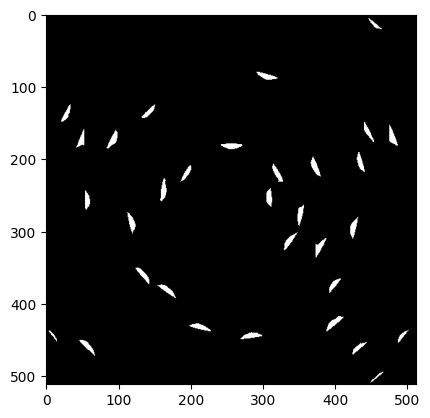

In [8]:
def labels_to_stim_mask(mask):
    """Take in a label image and return a mask for stimulation.
    For each label, we create a binary mask where the label is present.
    Then we take the 10% of each label's area closest to the image center to create a stimulation mask.
    """
    unique_labels = np.unique(mask)
    stim_mask = np.zeros_like(mask, dtype=bool)
    
    # Get image center
    center_y, center_x = np.array(mask.shape) / 2

    for label in unique_labels:
        if label == 0:  # Skip background
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        # Calculate number of pixels to keep (10% of label area)
        num_pixels_to_keep = int(label_area * 0.1)
        coords = np.argwhere(label_mask)

        # Compute distance to image center
        distances = np.linalg.norm(coords - np.array([center_y, center_x]), axis=1)

        # Sort coords by distance to center
        sorted_coords = coords[np.argsort(distances)]

        # Select closest 10%
        selected_coords = sorted_coords[:num_pixels_to_keep]

        # Mark selected pixels in stimulation mask
        stim_mask[selected_coords[:, 0], selected_coords[:, 1]] = True

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255

    return stim_mask

# Example usage:
stim_mask = labels_to_stim_mask(labels_ws)
plt.imshow(stim_mask, cmap='gray')

#### **Move towards letter (naive)**

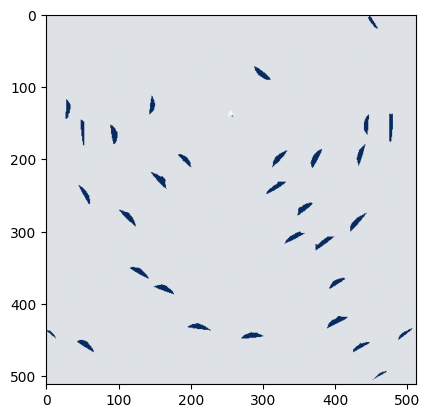

In [9]:
# Re-import libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def labels_to_stim_mask(mask, reference_mask, fraction=0.1):
    """
    Improved iterative label-to-stimulation mask assignment.
    
    - If a label overlaps the reference, stimulate the overlapping part.
    - If not, stimulate the closest label pixels (within the label) pointing toward available reference.
    
    Parameters:
    - mask: labeled image (e.g., from segmentation)
    - reference_mask: binary image with target region
    - fraction: fraction of label pixels to stimulate if not overlapping (default 10%)

    Returns:
    - stim_mask: binary stimulation mask (uint8)
    """
    stim_mask = np.zeros_like(mask, dtype=bool)
    available_mask = reference_mask.copy().astype(bool)
    unique_labels = np.unique(mask)

    for label in unique_labels:
        if label == 0:
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        overlap = label_mask & available_mask

        if np.any(overlap):
            # Case B: Directly stimulate overlapping area
            stim_mask[overlap] = True
            available_mask[overlap] = False
        else:
            # Case A: Stimulate inside label, directed toward nearest available reference
            if not np.any(available_mask):
                continue  # No reference area left

            distance_map = distance_transform_edt(~available_mask)
            coords = np.argwhere(label_mask)
            distances = distance_map[coords[:, 0], coords[:, 1]]

            # Choose closest label pixels
            sorted_coords = coords[np.argsort(distances)]
            num_pixels_to_keep = int(label_area * fraction)
            selected_coords = sorted_coords[:num_pixels_to_keep]

            for y, x in selected_coords:
                stim_mask[y, x] = True  # Always stimulate label pixels
                # Optional: you could "claim" nearby reference if needed here

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255


    return stim_mask



binary_ref_mask = mask_from_letter("A")

# Example usage:
stim_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
plt.imshow(stim_mask, cmap='Blues')
plt.imshow(binary_ref_mask, cmap='gray', alpha=0.1)

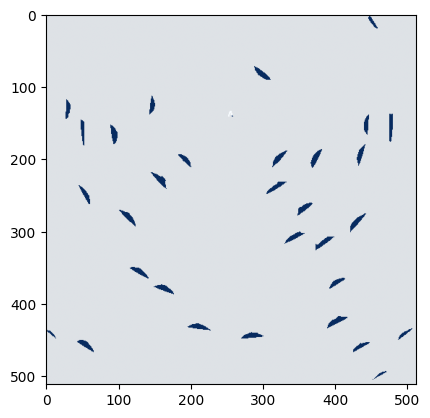

In [10]:
from scipy.ndimage import distance_transform_edt

def labels_to_stim_mask(mask, reference_mask):
    """
    Create a stimulation mask from a labeled mask.
    
    If a label overlaps the reference_mask, all overlapping pixels are included.
    Otherwise, the 10% of label pixels closest to reference_mask are selected.
    
    Parameters:
    - mask: labeled image (e.g., from segmentation)
    - reference_mask: binary mask (nonzero pixels define reference)
    
    Returns:
    - stim_mask: binary stimulation mask (uint8)
    """
    unique_labels = np.unique(mask)
    stim_mask = np.zeros_like(mask, dtype=bool)

    # Distance to nearest reference pixel
    distance_map = distance_transform_edt(~reference_mask.astype(bool))

    for label in unique_labels:
        if label == 0:
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        # Check if this label overlaps with the reference mask
        overlap = label_mask & reference_mask

        if np.any(overlap):
            # Case B: include all overlapping pixels
            stim_mask[overlap] = True
        else:
            # Case A: pick closest 10% to reference
            coords = np.argwhere(label_mask)
            distances = distance_map[coords[:, 0], coords[:, 1]]
            sorted_coords = coords[np.argsort(distances)]
            num_pixels_to_keep = int(label_area * 0.1)
            selected_coords = sorted_coords[:num_pixels_to_keep]
            stim_mask[selected_coords[:, 0], selected_coords[:, 1]] = True

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255

    return stim_mask


binary_ref_mask = mask_from_letter("A")


# Example usage:
stim_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
plt.imshow(stim_mask, cmap='Blues')
plt.imshow(binary_ref_mask, cmap='gray', alpha=0.1)

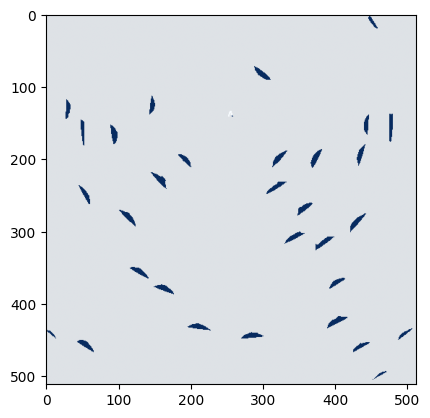

In [11]:
from scipy.ndimage import binary_dilation, distance_transform_edt
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, distance_transform_edt, generate_binary_structure
from collections import defaultdict

def update_dynamic_reference_mask_fast(mask, reference_mask, max_expansion=50, step=30):
    """
    Efficient dynamic reference mask using distance transform for expansion.

    Tries to remove expanded regions of labels that overlap the reference mask.
    If no unclaimed reference area is left, reduces expansion in large steps.

    Parameters:
    - mask: labeled segmentation mask
    - reference_mask: binary target mask
    - max_expansion: maximum expansion radius (default 50 px)
    - step: decrement step size for expansion radius (default 10 px)

    Returns:
    - dynamic_ref: binary mask with available reference regions
    """
    for r in range(max_expansion, -1, -step):
        dynamic_ref = reference_mask.copy().astype(bool)
        for label in np.unique(mask):
            if label == 0:
                continue
            label_mask = (mask == label)
            if np.any(label_mask & reference_mask):
                distance = distance_transform_edt(~label_mask)
                expanded = distance <= r
                dynamic_ref[expanded] = False
        if np.any(dynamic_ref):
            return dynamic_ref
    return reference_mask.copy().astype(bool)  # fallback if no area is left


def labels_to_stim_mask(mask, reference_mask, fraction=0.1, dilation_radius=70):
    """
    Smart stimulation mask assignment using a dynamic reference mask.
    
    - If label overlaps original reference: stimulate overlapping region
    - Else: compute distances to dynamic reference mask and steer toward it
    
    Parameters:
    - mask: labeled segmentation mask
    - reference_mask: binary target mask
    - fraction: fraction of label pixels to stimulate if not overlapping
    - dilation_radius: expansion radius (in pixels) to block out claimed regions

    Returns:
    - stim_mask: uint8 binary mask for stimulation
    """
    stim_mask = np.zeros_like(mask, dtype=bool)
    dynamic_ref = update_dynamic_reference_mask_fast(mask, reference_mask, dilation_radius)

    distance_map = distance_transform_edt(~dynamic_ref)
    unique_labels = np.unique(mask)

    for label in unique_labels:
        if label == 0:
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        overlap = label_mask & reference_mask

        if np.any(overlap):
            stim_mask[overlap] = True
        else:
            coords = np.argwhere(label_mask)
            distances = distance_map[coords[:, 0], coords[:, 1]]
            sorted_coords = coords[np.argsort(distances)]
            num_pixels_to_keep = int(label_area * fraction)
            selected_coords = sorted_coords[:num_pixels_to_keep]
            for y, x in selected_coords:
                stim_mask[y, x] = True

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255


    return stim_mask


binary_ref_mask = mask_from_letter("A")


# Example usage:
stim_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
plt.imshow(stim_mask, cmap='Blues')
plt.imshow(binary_ref_mask, cmap='gray', alpha=0.1)

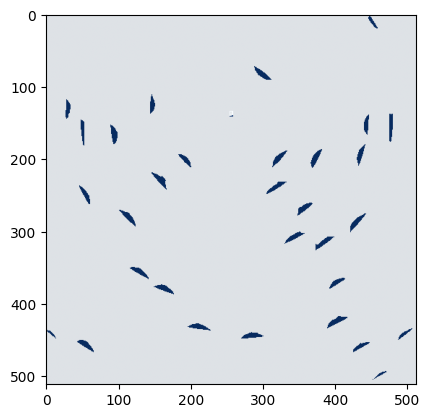

In [12]:
def labels_to_stim_mask(mask, reference_mask, fraction=0.1, expansion_radius=100):
    """
    Fast stimulation mask generation using a single distance transform on the reference mask.

    Parameters:
    - mask: labeled segmentation mask
    - reference_mask: binary target mask
    - fraction: fraction of label pixels to stimulate if not overlapping
    - expansion_radius: max distance (in px) from the reference to consider as reachable

    Returns:
    - stim_mask: uint8 binary mask for stimulation
    """
    stim_mask = np.zeros_like(mask, dtype=bool)
    reference_mask = reference_mask.astype(bool)
    global_distance = distance_transform_edt(~reference_mask)
    reachable_zone = global_distance <= expansion_radius

    unique_labels = np.unique(mask)
    claimed_mask = np.zeros_like(mask, dtype=bool)

    for label in unique_labels:
        if label == 0:
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        overlap = label_mask & reference_mask
        if np.any(overlap):
            stim_mask[overlap] = True
            claimed_mask[overlap] = True
        else:
            # Compute distance from label pixels to reachable zone
            coords = np.argwhere(label_mask)
            if coords.size == 0 or not np.any(reachable_zone):
                continue

            # Use the global distance map to reachable zone
            distances = global_distance[coords[:, 0], coords[:, 1]]
            sorted_indices = np.argsort(distances)
            num_pixels_to_keep = max(1, int(label_area * fraction))
            selected_coords = coords[sorted_indices[:num_pixels_to_keep]]

            stim_mask[selected_coords[:, 0], selected_coords[:, 1]] = True
            claimed_mask[selected_coords[:, 0], selected_coords[:, 1]] = True

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255

    return stim_mask

binary_ref_mask = mask_from_letter("B")


# Example usage:
stim_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
plt.imshow(stim_mask, cmap='Blues')
plt.imshow(binary_ref_mask, cmap='gray', alpha=0.1)

#### **Move towards letter (avoid already occupied areas)**

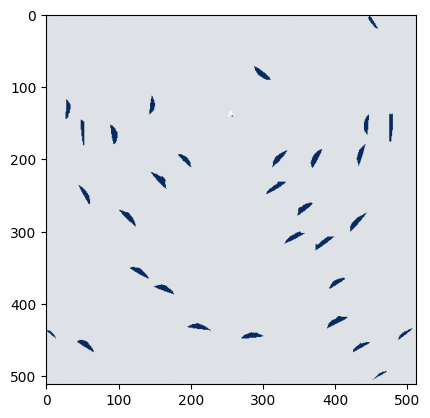

In [13]:
# Re-import necessary packages after code execution reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def labels_to_stim_mask(mask, reference_mask, fraction=0.1, expansion_radius=60):
    """
    Fast stimulation mask generation with improved masking of already-occupied reference areas.

    - Removes current label overlaps from the reference mask
    - Expands overlapping labels to reserve nearby regions before computing distance transform
    - If no free reference area remains, tries smaller expansion radii

    Parameters:
    - mask: labeled segmentation mask
    - reference_mask: binary target mask
    - fraction: fraction of label pixels to stimulate if not overlapping
    - expansion_radius: how far to expand overlapping labels to block off nearby areas

    Returns:
    - stim_mask: uint8 binary mask for stimulation
    """
    stim_mask = np.zeros_like(mask, dtype=bool)
    reference_mask = reference_mask.astype(bool)

    # Create a working copy of the reference mask
    overlapping_mask = np.zeros_like(mask, dtype=bool)
    for label in np.unique(mask):
        if label == 0:
            continue
        label_mask = (mask == label)
        if np.any(label_mask & reference_mask):
            overlapping_mask |= label_mask

    # Try decreasing expansion radius until reference area remains
    for radius in range(expansion_radius, -1, -10):
        working_ref = reference_mask.copy()
        if np.any(overlapping_mask):
            distance = distance_transform_edt(~overlapping_mask)
            expanded = distance <= radius
            working_ref[expanded] = False
        if np.any(working_ref):
            break

    if not np.any(working_ref):
        return np.zeros_like(mask, dtype=np.uint8)

    # Compute distance map to cleaned-up reference mask
    global_distance = distance_transform_edt(~working_ref)
    reachable_zone = global_distance <= expansion_radius

    # Go over labels again for stimulation
    for label in np.unique(mask):
        if label == 0:
            continue
        label_mask = (mask == label)
        label_area = np.sum(label_mask)
        if label_area == 0:
            continue

        overlap = label_mask & reference_mask
        if np.any(overlap):
            stim_mask[overlap] = True
        else:
            coords = np.argwhere(label_mask)
            if coords.size == 0 or not np.any(reachable_zone):
                continue

            distances = global_distance[coords[:, 0], coords[:, 1]]
            sorted_indices = np.argsort(distances)
            num_pixels_to_keep = max(1, int(label_area * fraction))
            selected_coords = coords[sorted_indices[:num_pixels_to_keep]]

            stim_mask[selected_coords[:, 0], selected_coords[:, 1]] = True

    # Convert to uint8 and black out 50px border
    stim_mask = stim_mask.astype(np.uint8) * 255
    return stim_mask


binary_ref_mask = mask_from_letter("A")
# Example usage:
stim_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
plt.imshow(stim_mask, cmap='Blues')
plt.imshow(binary_ref_mask, cmap='gray', alpha=0.1)

#### **Run the simulation**

100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


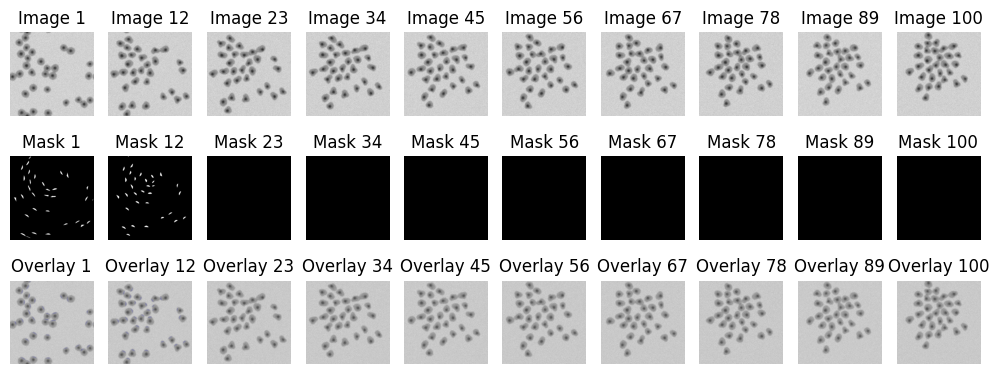

In [14]:
binary_ref_mask = mask_from_letter('A')


import tqdm
imgs = []
masks = []
overlay_masks = []
for i in tqdm.tqdm(range(100)):
    core.snapImage()
    camera_img = core.getImage()
    labels_ws = segment_cells(camera_img)
    stimulation_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
    # Update SLM with the stimulation mask
    core.setSLMImage("SLM", stimulation_mask)
    slm_img = core.getSLMImage("SLM")
    imgs.append(camera_img)
    masks.append(stimulation_mask)

    overlay = np.zeros_like(camera_img)
    overlay = np.stack([slm_img] * 3, axis=-1)
    overlay[slm_img > 0] = [0,255, 0]

    # Overlay the stimulation mask in green on the grayscale image
    # Normalize camera_img to 0-255 if not already
    img_rgb = np.stack([camera_img]*3, axis=-1)
    # Where slm_img > 0, set overlay to green
    overlay = img_rgb.copy()
    overlay[slm_img > 0] = [0, 0, 200]

    #mix the overlay with the original image, 50% each
    overlay = (overlay * 0.3 + img_rgb * 0.8).astype(np.uint8)

    overlay_masks.append(overlay)

# plot a 2x10 image grid of the images and masks
nb_plots = 10

fig, axes = plt.subplots(3, nb_plots, figsize=(nb_plots, 4))

frames = np.linspace(0, len(imgs) - 1, nb_plots, dtype=int)
for i in range(nb_plots):
    frame = frames[i]
    axes[0, i].imshow(imgs[frame], cmap='gray')
    axes[0, i].set_title(f"Image {frame+1}")
    axes[0, i].axis('off')
    axes[1, i].imshow(masks[frame], cmap='gray')
    
    axes[1, i].set_title(f"Mask {frame+1}")
    axes[1, i].axis('off')

    axes[2, i].imshow(imgs[frame], cmap='gray')
    axes[2, i].imshow(overlay_masks[frame], alpha=0.5)  # Overlay the mask
    axes[2, i].set_title(f"Overlay {frame+1}")
    axes[2, i].axis('off')

plt.tight_layout()

In [15]:
#make a video from the overlay, one frame per timepoint, save as 'overlay.mp4'
#save individual frames as 'overlay_frame_*.png'
# convert with ffmpeg to mp4
from skimage.io import imsave
for i, frame in enumerate(range(len(overlay_masks))):
    overlay = overlay_masks[i]
    imsave(f'out/overlay_frame_{i:03d}.png', overlay)
import os
os.system('ffmpeg -y -framerate 24 -i out/overlay_frame_%03d.png -c:v libx264 -pix_fmt yuv420p out/overlay.mp4')
# Clean up individual frames
for i in range(len(overlay_masks)):
    os.remove(f'out/overlay_frame_{i:03d}.png')

#### **Loop over string**
Run the simulation for each letter in the string, store each letter as movie.
Later the movies can be concatenated.

In [30]:
import microscope_sim

#simple loop of snap image, segment, update mask

#adjust nb cells for each letter.Reference: U, 66663px => 30 Cells
reference_px = 66663
reference_cells = 30

os.system('rm out/overlay_frame_*.png')
for order, letter in enumerate('PERTZ LAB '):
    binary_ref_mask = mask_from_letter(letter)
    nb_pixels = np.sum(binary_ref_mask > 0)
    print(f"Letter: {letter}, Number of pixels: {nb_pixels}")
    # compare with reference mask
    nb_cells = int(nb_pixels / reference_px * reference_cells)
    if nb_cells < 1:
        nb_cells = 1
    if nb_cells > 100:
        nb_cells = 40
    # exception for space
    if letter == " ":
        nb_cells = reference_cells


    core = UniMMCore()
    core.loadPyDevice("SLM", SimSLMDevice())
    core.initializeDevice("SLM")
    core.setSLMDevice("SLM")
    # Reset the simulation
    sim = microscope_sim.MicroscopeSim(nb_cells=nb_cells, overlay_mask=False)
    core.loadPyDevice("Camera", SimCameraDevice(core,microscope_sim=sim))
    core.initializeDevice("Camera")
    core.setCameraDevice("Camera")
    

    imgs = []
    masks = []
    overlay_masks = []
    for i in tqdm.tqdm(range(300)):
        core.snapImage()
        camera_img = core.getImage()
        labels_ws = segment_cells(camera_img)
        stimulation_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
        if letter == " ":
            stimulation_mask = np.zeros_like(stimulation_mask, dtype=np.uint8)
        core.setSLMImage("SLM", stimulation_mask)
        slm_img = core.getSLMImage("SLM")
        imgs.append(camera_img)
        masks.append(stimulation_mask)

        overlay = np.zeros_like(camera_img)
        overlay = np.stack([slm_img] * 3, axis=-1)
        overlay[slm_img > 0] = [0,255, 0]

        # Overlay the stimulation mask in green on the grayscale image
        # Normalize camera_img to 0-255 if not already
        img_rgb = np.stack([camera_img]*3, axis=-1)
        # Where slm_img > 0, set overlay to green
        overlay = img_rgb.copy()
        overlay[slm_img > 0] = [0, 0, 200]

        #mix the overlay with the original image, 50% each
        overlay = (overlay * 0.3 + img_rgb * 0.8).astype(np.uint8)
        overlay_masks.append(overlay)

    
    #make a video from the overlay, one frame per timepoint, save as 'overlay.mp4'
    #save individual frames as 'overlay_frame_*.png'
    # convert with ffmpeg to mp4
    for i, frame in enumerate(range(len(overlay_masks))):
        overlay = overlay_masks[i]
        imsave(f'out/overlay_frame_{i:03d}.png', overlay)

    order = str(order).zfill(3)
    if letter == " ":
        letter = "space"
    if letter == "<":
        letter = "space"
    os.system(f'ffmpeg -y -framerate 24 -i out/overlay_frame_%03d.png -c:v libx264 -pix_fmt yuv420p out/overlay_{order}_{letter}.mp4')
    # Clean up individual frames
    for i in range(len(overlay_masks)):
        os.remove(f'out/overlay_frame_{i:03d}.png')
# remove all the individual frames
os.system('rm out/overlay_frame_*.png')

Letter: P, Number of pixels: 21


  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
  0%|          | 1/300 [00:00<00:30,  9.66it/s]

Error getting SLM image: No image loaded


100%|██████████| 300/300 [00:49<00:00,  6.03it/s]


Letter: E, Number of pixels: 20


  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
  0%|          | 1/300 [00:00<00:50,  5.95it/s]

Error getting SLM image: No image loaded


100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


Letter: R, Number of pixels: 29


  0%|          | 0/300 [00:00<?, ?it/s]

Error getting SLM image: No image loaded


C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
100%|██████████| 300/300 [00:48<00:00,  6.13it/s]


Letter: T, Number of pixels: 14


  0%|          | 0/300 [00:00<?, ?it/s]

Error getting SLM image: No image loaded


C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
100%|██████████| 300/300 [00:47<00:00,  6.28it/s]


Letter: Z, Number of pixels: 25


  0%|          | 0/300 [00:00<?, ?it/s]

Error getting SLM image: No image loaded


C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Letter:  , Number of pixels: 0


  0%|          | 1/300 [00:00<00:34,  8.55it/s]

Error getting SLM image: No image loaded


100%|██████████| 300/300 [00:35<00:00,  8.48it/s]


Letter: L, Number of pixels: 12


  0%|          | 0/300 [00:00<?, ?it/s]

Error getting SLM image: No image loaded


C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
100%|██████████| 300/300 [00:47<00:00,  6.34it/s]


Letter: A, Number of pixels: 31


  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
  0%|          | 1/300 [00:00<00:34,  8.56it/s]

Error getting SLM image: No image loaded


100%|██████████| 300/300 [00:47<00:00,  6.30it/s]


Letter: B, Number of pixels: 30


  0%|          | 0/300 [00:00<?, ?it/s]

Error getting SLM image: No image loaded


C:\Users\dario\AppData\Local\Temp\ipykernel_14504\1804026478.py:19: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels_ws = remove_small_objects(labels_ws, min_size=min_size)
100%|██████████| 300/300 [00:58<00:00,  5.16it/s]


Letter:  , Number of pixels: 0


  0%|          | 1/300 [00:00<00:37,  7.97it/s]

Error getting SLM image: No image loaded


100%|██████████| 300/300 [00:38<00:00,  7.82it/s]


1

# Stack 2x5 videos

In [ ]:
ffmpeg -i overlay_000_*.mp4 -i overlay_001_*.mp4 -i overlay_002_*.mp4 -i overlay_003_*.mp4 -i overlay_004_*.mp4 -i overlay_005_*.mp4 -i overlay_006_*.mp4 -i overlay_007_*.mp4 -i overlay_008_*.mp4 -i overlay_009_*.mp4 -filter_complex "[0:v][1:v][2:v][3:v][4:v]hstack=inputs=5[top];[5:v][6:v][7:v][8:v][9:v]hstack=inputs=5[bottom];[top][bottom]vstack=inputs=2[out]" -map "[out]" -c:v libx264 -crf 18 -preset medium grid_5x2.mp4

# 1/2 the resolution of the output

In [ ]:
ffmpeg -i grid_5x2.mp4 -vf scale=1280:512 -c:v libx264 -crf 18 -preset medium grid_5x2_half_res.mp4

# parralel

In [31]:
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
from pathlib import Path
from imageio.v3 import imwrite as imsave

def process_letter_thread(letter, order):
    core = UniMMCore()
    core.loadPyDevice("SLM", SimSLMDevice())
    core.initializeDevice("SLM")
    core.setSLMDevice("SLM")
    
    core.loadPyDevice("Camera", SimCameraDevice(core, overlay_mask=False))
    core.initializeDevice("Camera")
    core.setCameraDevice("Camera")

    binary_ref_mask = mask_from_letter(letter)

    overlay_masks = []
    for i in range(300):
        core.snapImage()
        camera_img = core.getImage()
        labels_ws = segment_cells(camera_img)
        stimulation_mask = labels_to_stim_mask(labels_ws, binary_ref_mask)
        if letter == " ":
            stimulation_mask = np.zeros_like(stimulation_mask, dtype=np.uint8)
        core.setSLMImage("SLM", stimulation_mask)
        slm_img = core.getSLMImage("SLM")

        img_rgb = np.stack([camera_img]*3, axis=-1)
        overlay = img_rgb.copy()
        overlay[slm_img > 0] = [0, 0, 200]
        overlay = (overlay * 0.3 + img_rgb * 0.8).astype(np.uint8)
        overlay_masks.append(overlay)

    # Write frames
    out_dir = Path("out")
    out_dir.mkdir(exist_ok=True)
    for i, overlay in enumerate(overlay_masks):
        imsave(out_dir / f'overlay_frame_{i:03d}.png', overlay)

    order_str = str(order).zfill(3)
    letter_str = "space" if letter == " " else letter
    mp4_file = out_dir / f'overlay_{order_str}_{letter_str}.mp4'
    
    os.system(f'ffmpeg -y -framerate 24 -i out/overlay_frame_%03d.png -c:v libx264 -pix_fmt yuv420p {mp4_file}')
    
    # Clean up frames
    for i in range(len(overlay_masks)):
        os.remove(out_dir / f'overlay_frame_{i:03d}.png')


# Run in parallel using threads
letters = 'PERTZ LAB '
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(process_letter_thread, letter, order) for order, letter in enumerate(letters)]

# Wait for all threads to finish
for f in futures:
    f.result()

TypeError: SimCameraDevice.__init__() got an unexpected keyword argument 'overlay_mask'

# Display camera feed in widget

In [ ]:
from pymmcore_widgets import ExposureWidget, ImagePreview, LiveButton, SnapButton
from qtpy.QtWidgets import QApplication, QHBoxLayout, QVBoxLayout, QWidget

app = QApplication([])

window = QWidget()

window.setWindowTitle("Sim Microscope Camera Example")
layout = QVBoxLayout(window)

top = QHBoxLayout()
top.addWidget(SnapButton(mmcore=core))
top.addWidget(LiveButton(mmcore=core))
top.addWidget(ExposureWidget(mmcore=core))
layout.addLayout(top)
layout.addWidget(ImagePreview(mmcore=core))
window.setLayout(layout)
window.resize(800, 600)
window.show()
app.exec()

In [1]:
from pymmcore_plus import CMMCorePlus

mmc = CMMCorePlus().instance()

mmc.loadSystemConfiguration()

In [2]:
mmc.getAvailableConfigGroups()

('Camera', 'Channel', 'Channel-Multiband', 'LightPath', 'Objective', 'System')

In [4]:
mmc.getAvailableConfigs('Channel')

('Cy5', 'DAPI', 'FITC', 'Rhodamine')

In [10]:
mmc.getConfigState("Channel", "DAPI", native=True).getVerbose()

'<html>Dichroic:Label=400DCLP<br>Emission:Label=Chroma-HQ620<br>Excitation:Label=Chroma-D360<br>Core:Shutter=White Light Shutter<br></html>'